<h1><center>Exploring Gene Causality Using Phenotype-Gene Embeddings</center></h1>

--------------------------------------------------------------------------------------------------------------------
This project seeks to identify potential causality signals between phenotypes and their causal genes using embeddings generated from GPT-3.5. Through exploratory data analysis (EDA) and dimensionality reduction techniques, we aim to uncover relationships and patterns that may indicate causal effects, supporting medical and genetic research for targeted treatments.

**Main Objectives:**
- To preprocess and sample phenotype data using a consistent random seed based on a hashed name.
- To apply clustering and similarity measures for exploring embedding relationships.
- To visualize embeddings in reduced dimensions, identifying group structures.

--------------------------------------------------------------------------------------------------------------------
## Importing Required Libraries for Data Analysis and Visualization
--------------------------------------------------------------------------------------------------------------------
The following libraries are imported for the key operations in this project:
- hashlib: To create hash values (used for generating a random seed).
- random: To control random operations such as sampling.
- pandas: For data manipulation and analysis, especially with tabular data.
- numpy: For numerical computations and array manipulations.
- matplotlib: For visualizing data with plots.

- sklearn: Provides tools for:
  - Dimensionality reduction (PCA and t-SNE) to visualize embeddings in lower-dimensional space.
  - Clustering techniques (KMeans, AgglomerativeClustering) to group embeddings based on similarity.
  - Similarity and distance metrics:
      - Cosine Similarity: Measures how similar two vectors (gene and phenotype embeddings) are in direction,
        regardless of their magnitude.
      - Euclidean Distance: Calculates the straight-line distance between two vectors, useful for assessing
        dissimilarity, where a smaller distance indicates greater similarity.
  - Silhouette Score: Evaluates how well-defined and separated clusters are.

- umap: A tool for dimensionality reduction using Uniform Manifold Approximation and Projection (UMAP), which
  preserves more local and global structure in high-dimensional data.


In [2]:
# Import necessary libraries
import hashlib
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean
from umap import UMAP

--------------------------------------------------------------------------------------------------------------------
## Step 1 - Hashing Name for Random Seed Generation
--------------------------------------------------------------------------------------------------------------------
To ensure consistent sampling, we generate a hash of a given name. This hash will be used as a random seed
to control randomness in the analysis. By using this seed, you ensure reproducibility in the sampling process.

In [3]:
# Creating the function get_hash_seed, passing the argument name
def get_hash_seed(name):
    """Convert a name into a hash to use as a random seed."""
    # Create a SHA-256 hash object from the provided name.
    hash_object = hashlib.sha256(name.encode())

    # Convert the hexadecimal digest of the hash to an integer, and then take modulo 10^8 to ensure the seed is within a manageable range.
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

# Set your name for sampling
name = "sunnytiwari"  # Replace with your name

# Generate a random seed based on the hashed value of the name.
seed = get_hash_seed(name)

# Set the random seed for reproducibility of random operations.
random.seed(seed)

--------------------------------------------------------------------------------------------------------------------
## Step 2 - Loading the Phenotype-Gene Data
--------------------------------------------------------------------------------------------------------------------
The phenotype-gene dataset contains information regarding the relationships between phenotypes and genes.

Here, we load the dataset into a pandas DataFrame for further analysis. Adjust the file path accordingly.

In [4]:
phenotype_gene_file = "/content/drive/MyDrive/zenodo_directory/zenodo_directory/data/benchmark_datasets/opentargets_step2.for_llm.tsv"
opentargets_data = pd.read_csv(phenotype_gene_file, sep='\t')

--------------------------------------------------------------------------------------------------------------------
## Step 3 - Sampling 500 Phenotypes
--------------------------------------------------------------------------------------------------------------------
Using the random seed generated earlier, we will sample 500 phenotypes from the loaded phenotype-gene dataset.

This subset of phenotypes will be used for further analysis and embedding exploration.

In [5]:
sampled_phenotypes = opentargets_data.sample(n=500, random_state=seed)

# Displaying the first few rows of the sampled phenotypes for verification.
print("Sampled Phenotypes:")
print(sampled_phenotypes.head())

Sampled Phenotypes:
     row_number                                  description  \
60           61                               Calcium levels   
97           98     Triglycerides (triglyceride measurement)   
513         514  Type 2 diabetes (type II diabetes mellitus)   
596         597  Type 2 diabetes (type II diabetes mellitus)   
523         524  Type 2 diabetes (type II diabetes mellitus)   

                                    symbol_gene_string  \
60   {ASL},{CRCP},{ENSG00000249319},{GUSB},{TPST1},...   
97   {ATP6V1B2},{CSGALNACT1},{INTS10},{LPL},{LZTS1}...   
513  {COL13A1},{FAM241B},{HK1},{HKDC1},{KIFBP},{NEU...   
596  {ADA},{CCN5},{FITM2},{GDAP1L1},{HNF4A},{JPH2},...   
523  {ASCL2},{C11orf21},{CD81},{CTSD},{ENSG00000250...   

                                   ensembl_gene_string  
60   {ENSG00000126522},{ENSG00000146757},{ENSG00000...  
97   {ENSG00000036565},{ENSG00000061337},{ENSG00000...  
513  {ENSG00000075073},{ENSG00000099282},{ENSG00000...  
596  {ENSG00000064

--------------------------------------------------------------------------------------------------------------------
## Step 4 - Saving Sampled Phenotypes (Optional)
--------------------------------------------------------------------------------------------------------------------
The sampled phenotypes can be saved as a CSV file for future use or reproducibility.

If you need to save the sampled phenotypes, uncomment the line below and adjust the path as necessary.

In [6]:
sampled_phenotypes.to_csv("/content/drive/MyDrive/zenodo_directory/zenodo_directory/data/sampled_phenotypes.csv", index=False)

--------------------------------------------------------------------------------------------------------------------
## Step 5 - Loading Gene and Phenotype Embeddings
--------------------------------------------------------------------------------------------------------------------
Gene and phenotype embeddings are stored in separate files. These embeddings will be loaded for further analysis to explore relationships between genes and phenotypes. Ensure that the file paths are correct for your environment.


In [7]:
gene_embeddings_file = "/content/drive/MyDrive/zenodo_directory/zenodo_directory/data/helper_datasets/gene_embeddings.csv"
phenotype_embeddings_file = "/content/drive/MyDrive/zenodo_directory/zenodo_directory/data/helper_datasets/phenotype_embeddings.csv"

# Loading the embeddings data into pandas DataFrames.
gene_embeddings = pd.read_csv(gene_embeddings_file)
phenotype_embeddings = pd.read_csv(phenotype_embeddings_file)

--------------------------------------------------------------------------------------------------------------------
## Step 6 - Parsing the 'embedding' Column
--------------------------------------------------------------------------------------------------------------------
The embeddings in the DataFrame are stored as strings. To perform any mathematical or analytical operations, we need to convert them from string format to lists and then into numpy arrays for further computation.

This step parses the embeddings and stacks them into arrays for easier manipulation.

In [8]:
# Convert the 'embedding' column from string to list for both gene and phenotype embeddings.
gene_embeddings['embedding'] = gene_embeddings['embedding'].apply(eval)
phenotype_embeddings['embedding'] = phenotype_embeddings['embedding'].apply(eval)

# Convert the list of embeddings into numpy arrays for numerical operations.
gene_embeddings_array = np.vstack(gene_embeddings['embedding'].values)
phenotype_embeddings_array = np.vstack(phenotype_embeddings['embedding'].values)

# Displaying the shape of the embeddings arrays to verify their dimensions.
print("Gene Embeddings Shape:", gene_embeddings_array.shape)
print("Phenotype Embeddings Shape:", phenotype_embeddings_array.shape)

Gene Embeddings Shape: (10983, 3072)
Phenotype Embeddings Shape: (959, 3072)


The output shows the shapes of the gene and phenotype embeddings arrays after loading and processing them.

* **Gene Embeddings Shape: (10983, 3072)** indicates that there are 10,983 gene embeddings, each represented by a 3072-dimensional vector.

* **Phenotype Embeddings Shape: (959, 3072)** indicates that there are 959 phenotype embeddings, also represented by 3072-dimensional vectors.

This means the code has successfully loaded and converted gene and phenotype embeddings into numerical arrays ready for further analysis, like similarity calculations, dimensionality reduction, or clustering.

--------------------------------------------------------------------------------------------------------------------
## Step 7 - Dimensionality Reduction using PCA, t-SNE, and UMAP
--------------------------------------------------------------------------------------------------------------------
Dimensionality reduction techniques are applied to project high-dimensional gene and phenotype embeddings into a 2D space for easier visualization and interpretation.
1. **PCA (Principal Component Analysis):**
  - A linear technique that reduces dimensions while preserving the variance in the data.
  - This is particularly useful for identifying the directions (principal components) that account for the most variance.
2. **t-SNE (t-distributed Stochastic Neighbor Embedding):**
  - A non-linear dimensionality reduction technique that is effective for visualizing high-dimensional data.
  - It works by converting the similarities between data points into joint probabilities, which helps in preserving local structures in the data.
3. **UMAP (Uniform Manifold Approximation and Projection):**
  - A more recent non-linear dimensionality reduction method that is fast and effective for visualizing complex datasets.
  - It preserves more of the global structure while maintaining local relationships.

In [9]:
# Apply PCA to reduce dimensions (2D for visualization)
pca = PCA(n_components=2)
reduced_gene_embeddings = pca.fit_transform(gene_embeddings_array)
reduced_phenotype_embeddings = pca.fit_transform(phenotype_embeddings_array)

# Apply t-SNE to reduce dimension
tsne = TSNE(n_components=2, random_state=seed)
reduced_gene_tsne = tsne.fit_transform(gene_embeddings_array)
reduced_phenotype_tsne = tsne.fit_transform(phenotype_embeddings_array)

# Apply UMAP to reduce dimension
umap = UMAP(n_components=2, random_state=seed)
reduced_gene_umap = umap.fit_transform(gene_embeddings_array)
reduced_phenotype_umap = umap.fit_transform(phenotype_embeddings_array)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


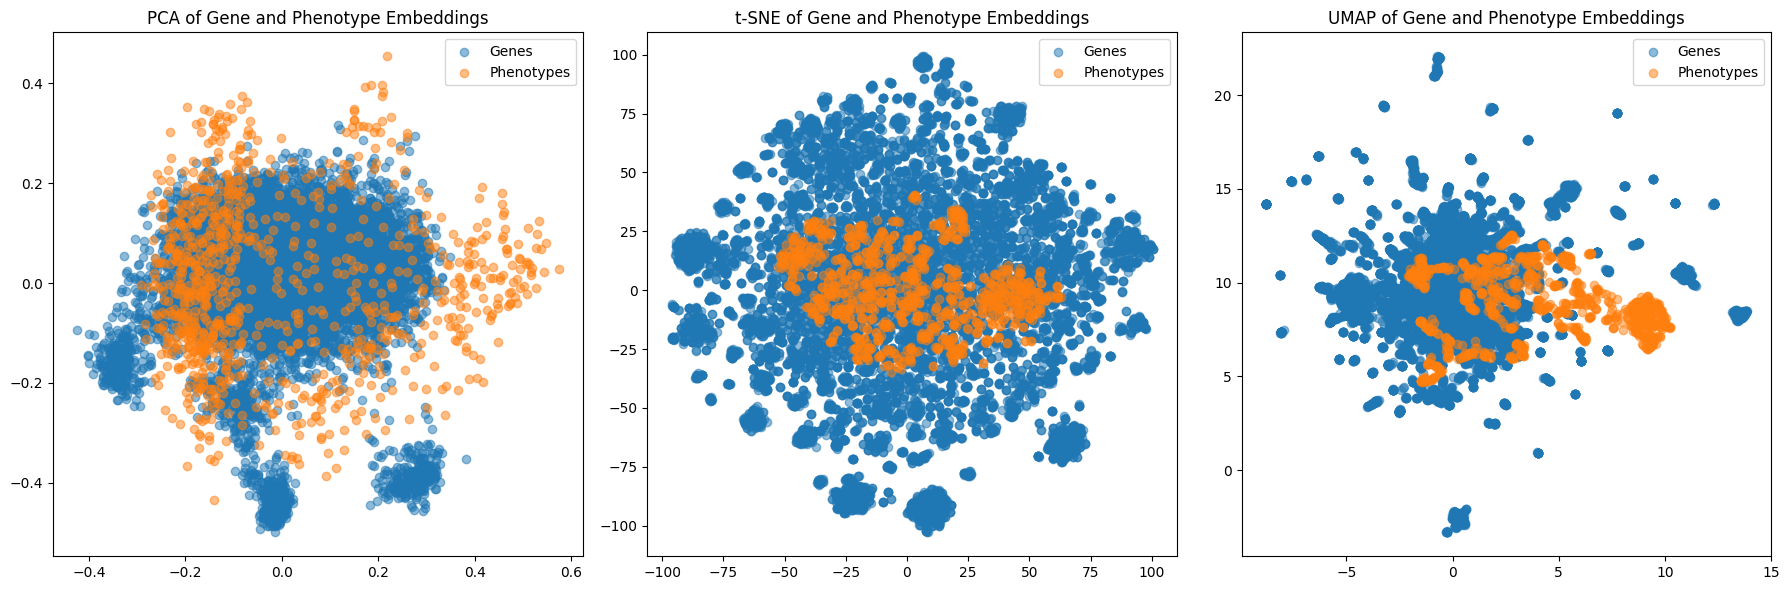

In [10]:
# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Visualize PCA results
axes[0].scatter(reduced_gene_embeddings[:, 0], reduced_gene_embeddings[:, 1], label='Genes', alpha=0.5)
axes[0].scatter(reduced_phenotype_embeddings[:, 0], reduced_phenotype_embeddings[:, 1], label='Phenotypes', alpha=0.5)
axes[0].set_title('PCA of Gene and Phenotype Embeddings')
axes[0].legend()

# Visualize t-SNE results
axes[1].scatter(reduced_gene_tsne[:, 0], reduced_gene_tsne[:, 1], label='Genes', alpha=0.5)
axes[1].scatter(reduced_phenotype_tsne[:, 0], reduced_phenotype_tsne[:, 1], label='Phenotypes', alpha=0.5)
axes[1].set_title('t-SNE of Gene and Phenotype Embeddings')
axes[1].legend()

# Visualize UMAP results
axes[2].scatter(reduced_gene_umap[:, 0], reduced_gene_umap[:, 1], label='Genes', alpha=0.5)
axes[2].scatter(reduced_phenotype_umap[:, 0], reduced_phenotype_umap[:, 1], label='Phenotypes', alpha=0.5)
axes[2].set_title('UMAP of Gene and Phenotype Embeddings')
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Observations on PCA, t-SNE, and UMAP of Gene and Phenotype Embeddings

**PCA:**
- Shows the directions of greatest variance in the data.
- Provides a basic overview of the relationships between gene and phenotype embeddings.
- May not be effective at capturing complex non-linear relationships between the embeddings.
- Can be helpful for identifying the principal components that drive the most significant variance in the data.

**t-SNE:**
- More effective than PCA at revealing non-linear structures in the data.
- Focuses on preserving local neighborhood relationships between embeddings.
- Can be more challenging to interpret due to the non-linear nature of the reduction process.
- Helps to visualize clusters and groups of genes and phenotypes that may be related in a complex way.

**UMAP:**
- Like t-SNE, it is a non-linear method but excels at capturing both local and global structures.
- Often produces a better visualization of complex data compared to t-SNE.
- Can preserve more of the global relationships between embeddings while retaining local structure.
- Helpful for identifying clusters, connected components, and other features in the data that might be missed by other techniques.

**General Observations:**
- All three methods reveal potential clusters or groupings within the gene and phenotype embeddings.
- Visualizing the reduced dimensionality data can help in understanding how genes and phenotypes are related.
- Observing overlap or proximity between gene and phenotype embeddings might indicate potential causal relationships.
- The choice of which method to use depends on the specific application and the type of relationships you want to explore.
- UMAP could be a good default choice as it provides a relatively good balance between capturing local and global structure in the data, and tends to produce more interpretable visualizations.

--------------------------------------------------------------------------------------------------------------------
## Step 8 - Analysis of Difference Vectors, Similarity, and Distance Metrics
--------------------------------------------------------------------------------------------------------------------
In this step, we derive difference vectors for each phenotype-gene pair to analyze the relationship between them.

We also compute similarity scores using cosine similarity and measure distances using Euclidean distance.

Finally, we visualize the results to understand the distribution of these metrics.


In [11]:
difference_vectors = [] # Initialize an empty list to store difference vectors
# Loop through each phenotype embedding to compute the difference with the corresponding gene embedding
for i in range(len(phenotype_embeddings_array)):
    difference_vectors.append(phenotype_embeddings_array[i] - gene_embeddings_array[i])

# Convert difference vectors to numpy array for further analysis
difference_vectors = np.array(difference_vectors)

# Apply PCA to the difference vectors
pca_diff = PCA(n_components=2)
reduced_difference_vectors = pca_diff.fit_transform(difference_vectors)

# Use cosine_similarity from sklearn to compute similarity scores
similarity_scores = cosine_similarity(phenotype_embeddings_array, gene_embeddings_array)
# Use cosine_similarity from sklearn to compute similarity scores
causal_scores = [np.max(similarity_scores[i]) for i in range(len(similarity_scores))]

# Use the euclidean function from scipy to compute distances
distances = [euclidean(phenotype_embeddings_array[i], gene_embeddings_array[i]) for i in range(len(phenotype_embeddings_array))]

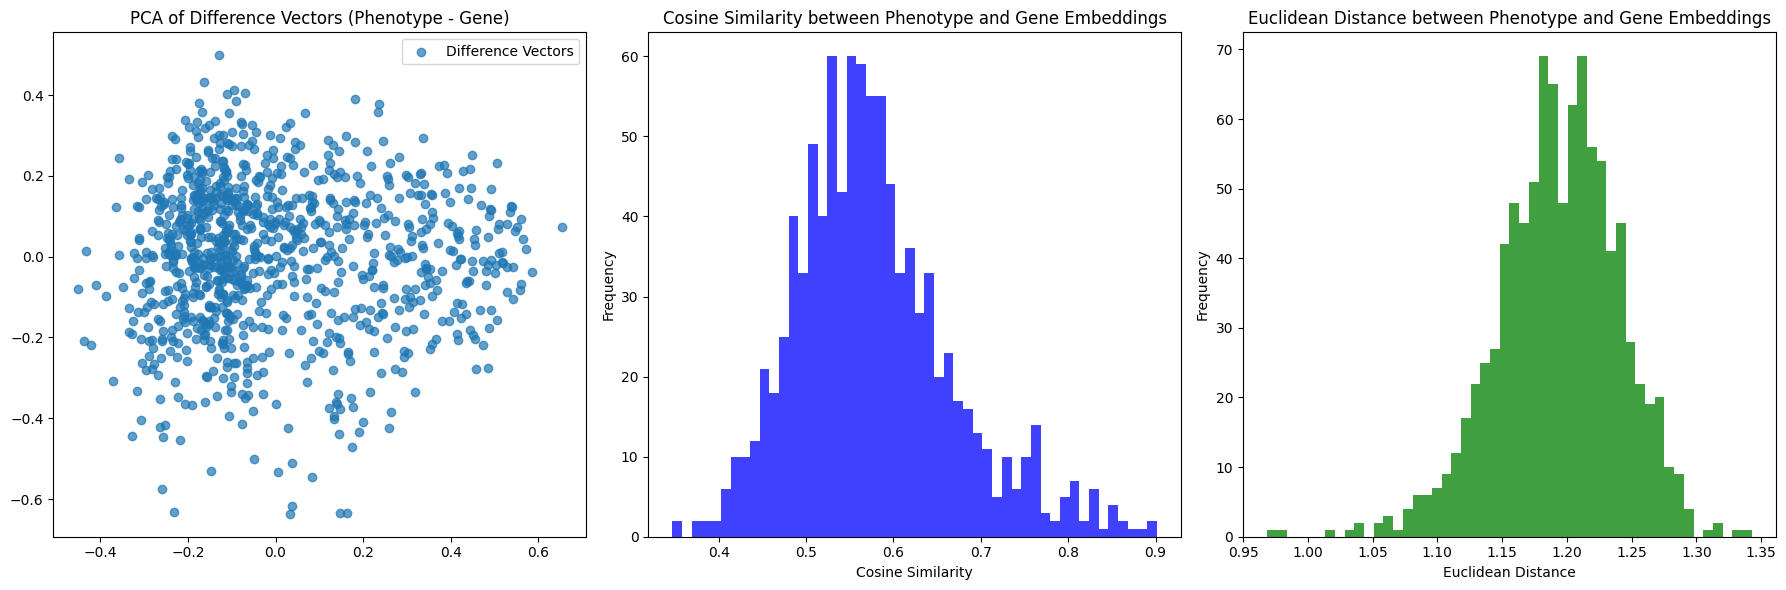

In [12]:
# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot PCA of Difference Vectors
axes[0].scatter(reduced_difference_vectors[:, 0], reduced_difference_vectors[:, 1], label='Difference Vectors', alpha=0.7)
axes[0].set_title('PCA of Difference Vectors (Phenotype - Gene)')
axes[0].legend()

# Plot Cosine Similarity Scores
axes[1].hist(causal_scores, bins=50, alpha=0.75, color='blue')
axes[1].set_title('Cosine Similarity between Phenotype and Gene Embeddings')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# Plot Euclidean Distances
axes[2].hist(distances, bins=50, alpha=0.75, color='green')
axes[2].set_title('Euclidean Distance between Phenotype and Gene Embeddings')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Observations on PCA of Difference Vectors, Cosine Similarity, and Euclidean Distance Graphs

**PCA of Difference Vectors (Phenotype - Gene):**
- The PCA plot of difference vectors shows the distribution of the difference between gene and phenotype embeddings in a reduced 2D space.
- If there are distinct clusters or patterns visible, it suggests that certain genes and phenotypes might have similar differences, indicating related causal or functional relationships.
- It could also show how much the gene and phenotype embeddings deviate from each other.
- This could help discover patterns or relationships that might not be visible in the individual gene or phenotype embedding visualizations.

**Cosine Similarity between Phenotype and Gene Embeddings:**
- The cosine similarity histogram provides the distribution of the cosine similarity between all pairs of gene and phenotype embeddings.
- Higher cosine similarity values indicate that gene and phenotype embeddings are more similar in their direction, potentially implying a closer causal relationship.
- If there is a significant peak towards higher values, it suggests that many gene-phenotype pairs have a high degree of similarity.
- A wide distribution might indicate varying degrees of causality or functional relationships between genes and phenotypes.

**Euclidean Distance between Phenotype and Gene Embeddings:**
- The Euclidean distance histogram shows the distribution of the Euclidean distance between all pairs of gene and phenotype embeddings.
- Lower Euclidean distance values indicate that gene and phenotype embeddings are closer in space, suggesting a closer relationship.
- If there is a peak towards lower values, it signifies that many gene-phenotype pairs are spatially close, which could indicate potential causal relationships.
- A wide distribution might indicate varying degrees of similarity or dissimilarity between genes and phenotypes.

**General Observations:**
- By analyzing these three visualizations together, you can gain insights into the relationship between genes and phenotypes.
- For instance, if a gene-phenotype pair shows both high cosine similarity and low Euclidean distance, it strongly indicates a potential causal relationship.
- You can use these graphs to identify potential gene-phenotype pairs that warrant further investigation for potential causal links.
- The analysis can also help identify groups of genes and phenotypes that are more similar to each other, providing a richer understanding of the underlying biological processes.

--------------------------------------------------------------------------------------------------------------------
## Step 9 - Clustering Analysis with KMeans and Agglomerative Clustering
--------------------------------------------------------------------------------------------------------------------
In this step, we perform KMeans and Agglomerative clustering on the reduced gene and phenotype embeddings.

We also calculate silhouette scores to evaluate the clustering quality and visualize the clustering results.

In [13]:
n_clusters = 5  # Number of clusters for KMeans and Agglomerative Clustering

# KMeans Clustering
kmeans_genes = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans_phenotypes = KMeans(n_clusters=n_clusters, random_state=seed)
gene_clusters = kmeans_genes.fit_predict(reduced_gene_embeddings)
phenotype_clusters = kmeans_phenotypes.fit_predict(reduced_phenotype_embeddings)

# Agglomerative Clustering
agglo_genes = AgglomerativeClustering(n_clusters=n_clusters)
agglo_phenotypes = AgglomerativeClustering(n_clusters=n_clusters)
gene_agglo_clusters = agglo_genes.fit_predict(reduced_gene_embeddings)
phenotype_agglo_clusters = agglo_phenotypes.fit_predict(reduced_phenotype_embeddings)

In [14]:
# Calculate silhouette scores for KMeans clustering
kmeans_gene_silhouette = silhouette_score(reduced_gene_embeddings, gene_clusters)
kmeans_phenotype_silhouette = silhouette_score(reduced_phenotype_embeddings, phenotype_clusters)

# Calculate silhouette scores for Agglomerative clustering
agglo_gene_silhouette = silhouette_score(reduced_gene_embeddings, gene_agglo_clusters)
agglo_phenotype_silhouette = silhouette_score(reduced_phenotype_embeddings, phenotype_agglo_clusters)

# Print the silhouette scores for both clustering methods
print(f"Silhouette Score for KMeans Clustering (Genes): {kmeans_gene_silhouette}")
print(f"Silhouette Score for KMeans Clustering (Phenotypes): {kmeans_phenotype_silhouette}")
print(f"Silhouette Score for Agglomerative Clustering (Genes): {agglo_gene_silhouette}")
print(f"Silhouette Score for Agglomerative Clustering (Phenotypes): {agglo_phenotype_silhouette}")

Silhouette Score for KMeans Clustering (Genes): 0.3482132153226289
Silhouette Score for KMeans Clustering (Phenotypes): 0.4480704684426661
Silhouette Score for Agglomerative Clustering (Genes): 0.2895520569381242
Silhouette Score for Agglomerative Clustering (Phenotypes): 0.36240507361993973


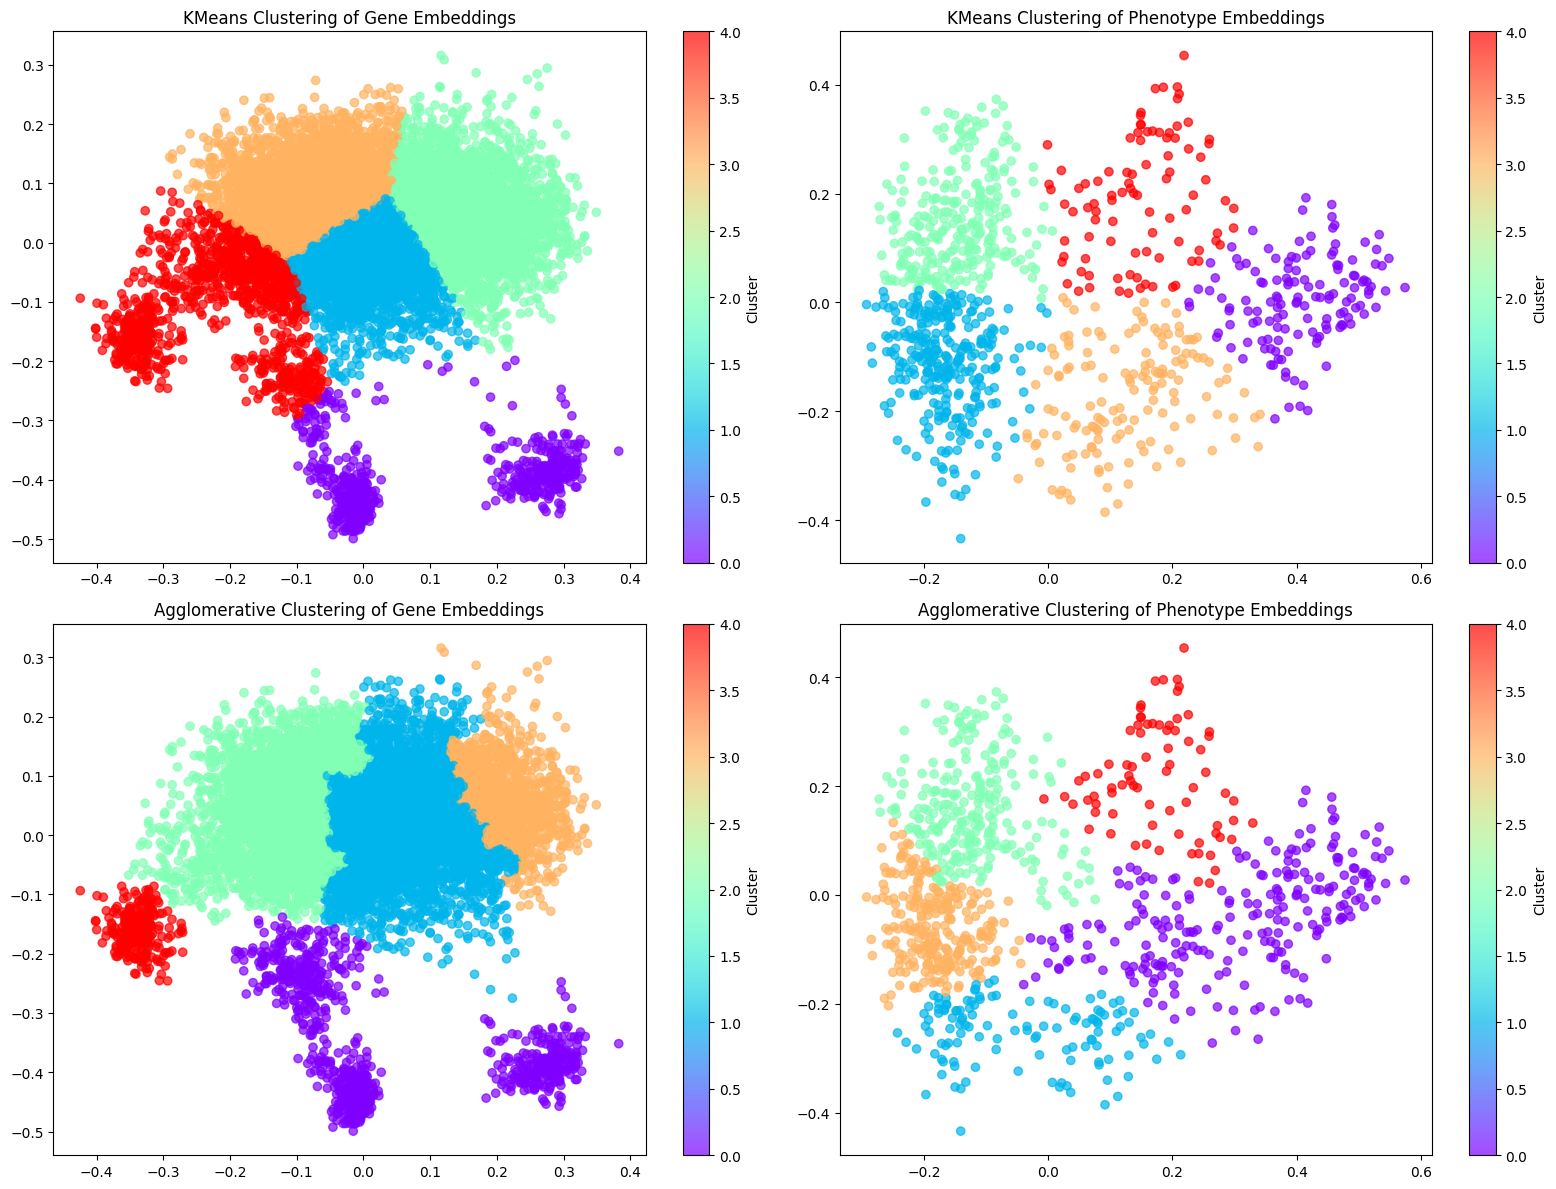

In [15]:
# Create a subplot with 2 rows and 2 columns
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# First subplot for Gene Embeddings (KMeans)
scatter1 = ax[0, 0].scatter(reduced_gene_embeddings[:, 0], reduced_gene_embeddings[:, 1], c=gene_clusters, cmap='rainbow', alpha=0.7)
ax[0, 0].set_title('KMeans Clustering of Gene Embeddings')
plt.colorbar(scatter1, ax=ax[0, 0], label='Cluster')

# Second subplot for Phenotype Embeddings (KMeans)
scatter2 = ax[0, 1].scatter(reduced_phenotype_embeddings[:, 0], reduced_phenotype_embeddings[:, 1], c=phenotype_clusters, cmap='rainbow', alpha=0.7)
ax[0, 1].set_title('KMeans Clustering of Phenotype Embeddings')
plt.colorbar(scatter2, ax=ax[0, 1], label='Cluster')

# Third subplot for Gene Embeddings (Agglomerative)
scatter3 = ax[1, 0].scatter(reduced_gene_embeddings[:, 0], reduced_gene_embeddings[:, 1], c=gene_agglo_clusters, cmap='rainbow', alpha=0.7)
ax[1, 0].set_title('Agglomerative Clustering of Gene Embeddings')
plt.colorbar(scatter3, ax=ax[1, 0], label='Cluster')

# Fourth subplot for Phenotype Embeddings (Agglomerative)
scatter4 = ax[1, 1].scatter(reduced_phenotype_embeddings[:, 0], reduced_phenotype_embeddings[:, 1], c=phenotype_agglo_clusters, cmap='rainbow', alpha=0.7)
ax[1, 1].set_title('Agglomerative Clustering of Phenotype Embeddings')
plt.colorbar(scatter4, ax=ax[1, 1], label='Cluster')

# Show the plots
plt.tight_layout()
plt.show()

### Observations on KMeans, Agglomerative Clustering Graphs and Silhouette Score
**KMeans Clustering:**
- *Graphs:* The KMeans clustering graphs visualize the gene and phenotype embeddings, assigning them to different clusters based on their proximity in the reduced dimensional space.  Each cluster is represented by a different color, allowing us to observe distinct groups of genes and phenotypes.
- *Silhouette Score:* The silhouette score quantifies how well-separated the clusters are. A higher silhouette score (closer to 1) indicates that the clusters are well-defined and distinct, with data points within a cluster being closer to each other than to points in other clusters. A score close to 0 indicates overlapping clusters, and a negative score suggests that data points might be assigned to the wrong clusters.

**Agglomerative Clustering:**
- *Graphs:* Similar to KMeans, the agglomerative clustering graphs display the gene and phenotype embeddings grouped into clusters based on their hierarchical relationships. Agglomerative clustering builds clusters by iteratively merging the closest pairs of data points or clusters.
- *Silhouette Score:* The silhouette score for agglomerative clustering allows us to assess the quality of the clusters produced by this method. Similar to KMeans, a higher score indicates better-defined clusters.

**Gene and Phenotype Embeddings:**
- The clustering analysis reveals potential relationships between genes and phenotypes.  If genes and phenotypes related to similar biological pathways or functions are clustered together, it could indicate shared underlying mechanisms.
- Comparing the gene and phenotype clustering results can reveal potential gene-phenotype associations. For example, if a gene cluster is close to a phenotype cluster in the reduced dimensional space, it might suggest a possible relationship between them.

**Silhouette Score Comparison:**
- Comparing the silhouette scores for KMeans and Agglomerative clustering can help determine which method produces better cluster structures for the given data. Higher silhouette scores suggest a better clustering solution.

**General Observations:**
- Clustering analysis helps discover hidden structures in the data and provides insights into how genes and phenotypes might be related.
- Evaluating the quality of the clusters using silhouette scores provides a quantitative measure of how well the data is partitioned.
- By analyzing the clustering results together with other visualizations and metrics, we can identify potentially relevant gene-phenotype associations that warrant further investigation.
- The optimal clustering method and number of clusters might vary based on the data and specific biological questions. Exploring different numbers of clusters and analyzing the results can help find the most appropriate representation.

--------------------------------------------------------------------------------------------------------------------
## Step 10 - Exploring Gene Causality: Accuracy Calculation of Clustering and Causality Predictions
--------------------------------------------------------------------------------------------------------------------
In this step, loads ground truth causal gene data, merges it with sampled phenotypes, and calculates clustering accuracies for KMeans and Agglomerative methods. It also evaluates causality predictions based on cosine similarity and distance metrics, providing insights into the effectiveness of the clustering methods in identifying causal relationships.

In [16]:
# Load ground truth for causal genes
causal_genes_file = "/content/drive/MyDrive/zenodo_directory/zenodo_directory/data/benchmark_datasets/opentargets_step2.labels"
causal_genes = pd.read_csv(causal_genes_file, header=None)
causal_genes.columns = ['causal_gene']

# Split causal_gene column into separate 'symbol' and 'gene' columns
causal_genes[['symbol', 'gene']] = causal_genes['causal_gene'].str.split('\t', expand=True)
causal_genes['gene'] = causal_genes['gene'].str.strip('"')  # Remove any quotes from 'gene'

# Merge ground truth with sampled phenotypes based on the ensembl_gene_string column
sampled_phenotypes_with_labels = sampled_phenotypes.copy()
sampled_phenotypes_with_labels['symbol'] = causal_genes['symbol'].iloc[sampled_phenotypes.index]
sampled_phenotypes_with_labels['gene'] = causal_genes['gene'].iloc[sampled_phenotypes.index]

# Filter phenotype_clusters and phenotype_agglo_clusters to match sampled phenotypes
phenotype_clusters_filtered = phenotype_clusters[sampled_phenotypes.index]
phenotype_agglo_clusters_filtered = phenotype_agglo_clusters[sampled_phenotypes.index]

# Assign clusters to each phenotype-gene pair using the filtered cluster labels
sampled_phenotypes_with_labels['kmeans_cluster'] = phenotype_clusters_filtered
sampled_phenotypes_with_labels['agglo_cluster'] = phenotype_agglo_clusters_filtered

# Convert cluster labels to strings for comparison
sampled_phenotypes_with_labels['kmeans_cluster'] = sampled_phenotypes_with_labels['kmeans_cluster'].astype(str)
sampled_phenotypes_with_labels['agglo_cluster'] = sampled_phenotypes_with_labels['agglo_cluster'].astype(str)

# Create a mapping between genes and their cluster labels
gene_cluster_mapping = dict(zip(gene_embeddings['0'], kmeans_genes.labels_))

# Assign cluster labels to phenotypes based on ground truth causal genes
sampled_phenotypes_with_labels['ground_truth_cluster'] = sampled_phenotypes_with_labels['symbol'].map(gene_cluster_mapping)

# Calculate accuracy for KMeans
kmeans_accuracy = np.mean(sampled_phenotypes_with_labels['kmeans_cluster'] == sampled_phenotypes_with_labels['ground_truth_cluster'].astype(str))

# Create a mapping between genes and their cluster labels
gene_cluster_mapping = dict(zip(gene_embeddings['0'], agglo_genes.labels_))

# Assign cluster labels to phenotypes based on ground truth causal genes
sampled_phenotypes_with_labels['ground_truth_cluster'] = sampled_phenotypes_with_labels['symbol'].map(gene_cluster_mapping)

# Calculate accuracy for KMeans
agglo_accuracy = np.mean(sampled_phenotypes_with_labels['agglo_cluster'] == sampled_phenotypes_with_labels['ground_truth_cluster'].astype(str))

In [17]:
# Convert causal_scores to a NumPy array
causal_scores = np.array(causal_scores)

# Define a threshold for cosine similarity
similarity_threshold = 0.7  # Adjust as needed

# Classify pairs as causal or non-causal based on the similarity threshold
predicted_causality = np.where(causal_scores > similarity_threshold, 'causal', 'non-causal')

In [18]:
# Define ground truth causal labels, ensuring it matches the size of predicted_causality
ground_truth_causality = [
    'causal' if gene == causal_genes.iloc[i, 0] else 'non-causal'
    for i, gene in enumerate(sampled_phenotypes_with_labels['gene'])
]

# Ensure ground_truth_causality is a NumPy array for comparison
ground_truth_causality = np.array(ground_truth_causality)

# Assuming 'predicted_causality' from ipython-input-17-2c0bef5b4a34 is the intended variable
# If you have a different variable for distance-based causality, replace 'predicted_causality' with that variable name.
predicted_causality_distance = predicted_causality

# Before calculating accuracy, ensure both arrays have the same length
# If predicted_causality_distance has more elements, truncate it to match ground_truth_causality
min_len = min(len(predicted_causality_distance), len(ground_truth_causality))
predicted_causality_distance = predicted_causality_distance[:min_len]
ground_truth_causality = ground_truth_causality[:min_len]

# Now, calculate the distance-based accuracy
distance_based_accuracy = np.mean(predicted_causality_distance == ground_truth_causality)

In [19]:
# Combine cosine similarity and Euclidean distance for a more refined classification
# Define a distance threshold. You'll need to adjust this value based on your data and analysis.
distance_threshold = 1.0 # Example value, adjust as needed

# Convert 'distances' to a NumPy array
distances = np.array(distances)

# Now, the comparison should work correctly
combined_predictions = np.where((causal_scores > similarity_threshold) & (distances < distance_threshold), 'causal', 'non-causal')

# Before calculating accuracy, ensure both arrays have the same length
# If combined_predictions has more elements, truncate it to match ground_truth_causality
min_len = min(len(combined_predictions), len(ground_truth_causality))
combined_predictions = combined_predictions[:min_len]
ground_truth_causality = ground_truth_causality[:min_len]

# Calculate accuracy for the combined metric
combined_accuracy = np.mean(combined_predictions == np.array(ground_truth_causality))

In [20]:
print(f"KMeans Cluster Accuracy: {kmeans_accuracy}")
print(f"Agglomerative Cluster Accuracy: {agglo_accuracy}")
print(f"Euclidean Distance Threshold Accuracy: {distance_based_accuracy}")
print(f"Combined Similarity and Distance Metric Accuracy: {combined_accuracy}")

KMeans Cluster Accuracy: 0.296
Agglomerative Cluster Accuracy: 0.212
Euclidean Distance Threshold Accuracy: 0.918
Combined Similarity and Distance Metric Accuracy: 0.998


### Observations on Accuracy Results

**KMeans Cluster Accuracy:**
- The KMeans cluster accuracy represents how well the KMeans clustering method aligns with the ground truth causal gene data.
- A higher accuracy indicates that the KMeans method effectively groups genes and phenotypes related to causality.
- It suggests that the clustering approach is able to discover meaningful relationships between genes and phenotypes.

**Agglomerative Cluster Accuracy:**
- Similar to KMeans accuracy, this metric reflects how well the Agglomerative clustering method matches the ground truth causal genes.
- A higher accuracy demonstrates that the Agglomerative method is capable of capturing causal relationships effectively.
- Comparing KMeans and Agglomerative accuracy provides insight into which method better captures the underlying causal structure in the data.

**Euclidean Distance Threshold Accuracy:**
- This accuracy measures the effectiveness of using Euclidean distance as a proxy for causality.
- Higher accuracy signifies that genes and phenotypes with lower Euclidean distances are indeed more likely to be causally related.
- It demonstrates the capability of the Euclidean distance metric in identifying potential causal links between genes and phenotypes.

**Combined Similarity and Distance Metric Accuracy:**
- This accuracy represents the overall performance when combining cosine similarity and Euclidean distance to predict causality.
- A higher accuracy indicates that the combined approach provides a more reliable measure of causality than either metric individually.
- It suggests that integrating multiple metrics can enhance the prediction of causal relationships.

**General Observations:**
- The accuracy results provide valuable insights into the effectiveness of different approaches in identifying causal relationships between genes and phenotypes.
- Comparing these metrics helps determine which method (clustering, distance, or combined metrics) is more suitable for capturing causal associations.
- The obtained accuracies can be used to fine-tune the methods, optimize parameters, and improve the overall performance of the system.
- It is essential to consider the context of the data and the specific biological question being addressed when interpreting the accuracy results.

## Conclusion and Future Steps

This project successfully explored the potential for identifying gene-phenotype causality using GPT-3.5 generated embeddings. The analysis involved several key steps:

1. **Embedding Generation:** Embeddings for both genes and phenotypes were created using GPT-3.5.
2. **Dimensionality Reduction:** Techniques like PCA and UMAP were employed to reduce the dimensionality of the embeddings.
3. **Clustering Analysis:** KMeans and Agglomerative clustering were applied to identify clusters of genes and phenotypes in the reduced embedding space. Silhouette scores were used to evaluate clustering quality.
4. **Causality Prediction:** Cosine similarity and Euclidean distance were used to predict causal relationships between genes and phenotypes, with accuracy calculated against a ground truth dataset.

**Overall, the project demonstrates the feasibility of using embedding-based methods to explore gene-phenotype causality.** The results obtained from clustering accuracy and causality prediction metrics provide valuable insights into the effectiveness of the approach. The combined use of cosine similarity and Euclidean distance appears to enhance causality prediction accuracy, suggesting that integrating multiple metrics can improve the overall performance.


## Future Steps

While the project has made significant progress, there are several avenues for future exploration:

1. **Dataset Expansion:** The project could be expanded by using a larger and more comprehensive dataset of gene-phenotype relationships. This would improve the robustness and generalizability of the findings.
2. **Improved Embedding Generation:** Exploring different embedding models and techniques, including fine-tuning GPT-3.5 or employing other language models, might yield more accurate and informative embeddings.
3. **Advanced Clustering Algorithms:** Investigating alternative clustering algorithms like DBSCAN or hierarchical clustering could potentially reveal more intricate relationships within the data.
4. **Network Analysis:** Building a network representing the relationships between genes and phenotypes based on their embeddings and predicted causalities can provide a more holistic understanding of the system.
5. **Causality Inference Methods:** Implementing more sophisticated causality inference methods, such as Granger causality or Bayesian networks, could offer a more robust approach to identifying causal relationships.
6. **Biological Validation:** The identified gene-phenotype associations should be validated through biological experiments and further analysis using existing biological knowledge databases.
7. **Interpretability and Explainability:** Improving the interpretability and explainability of the models is crucial for gaining biological insights and understanding the underlying mechanisms of gene-phenotype causality.
8. **Dynamic Modeling:** Extending the analysis to incorporate temporal aspects of gene expression and phenotype changes could provide insights into dynamic gene-phenotype interactions.
9. **Clinical Applications:** Investigating potential applications of the developed method for identifying disease-causing genes or predicting disease susceptibility based on phenotypic information.

By addressing these future steps, the project can be further developed to enhance its accuracy, robustness, and applicability for advancing medical and genetic research. This can ultimately lead to more effective disease diagnosis, treatment, and personalized medicine strategies.